In [1]:
import logging
import random
from datetime import timedelta
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_DATA", one_hot=True)


c:\users\dan\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\dan\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\dan\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\dan\anaconda3\envs\tensorflow-gpu\lib\site-

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_DATA\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_DATA\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_DATA\t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
def sort_by_fscore(networks):
    for i in range(len(networks)):
        for j in range(len(networks) - 1):
            if networks[j].fscore[2] < networks[j + 1].fscore[2]:
                networks[j], networks[j + 1] = networks[j + 1], networks[j]


def weight_variable(shape):
    initial = tf.random.truncated_normal(shape=shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape, dtype=None, name="Const")
    return tf.Variable(initial)


def conv2d(x, w, padding='SAME'):
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding=padding)


def max_pooling_2x2(x, padding='SAME'):
    return tf.nn.max_pool2d(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=padding)

In [3]:

class Network:
    # scores for data will be kept in the following order:
    # fscore, accuracy, recall, precision = ['train', 'validation', 'test']
    class DataType:
        Names = ["TRAIN", "VALIDATION", "TEST"]
        TRAIN = 0
        VALIDATION = 1
        TEST = 2

    def __init__(self, session, network_type, batch_size=100, num_iterations=13000, keep_probability_value=0.5):
        """
        :type session: tensorflow session object
        :type network_type: network creator function pointer
        """
        self.fscore = [0, 0, 0]
        self.accuracy = [0, 0, 0]
        self.recall = [0, 0, 0]
        self.precision = [0, 0, 0]
        self.keep_probability_value = keep_probability_value
        self.x_placeholder = None
        self.z_variables = None
        self.keep_prob_placeholder = None
        self.target_placeholder = None
        self.session = session
        self.batch_size = batch_size
        self.num_iterations = num_iterations
        self.net_type = network_type
        self.net = None
        self.train_time = timedelta(seconds=0)
        self.num_weights_in_net = None
        self.net_parameters = None
        self.is_conv_net = False

    def run(self):
        self.build_train()
        self.test_all_scores()

    def build_train(self):
        self.net = self.net_type()  # create network

        self.x_placeholder = self.net[0]
        self.z_variables = self.net[1]
        self.keep_prob_placeholder = self.net[2]
        self.target_placeholder = self.net[3]

        self.net_parameters = self.net[4]

        self.num_weights_in_net = self.net_parameters[4]
        if self.keep_prob_placeholder is not None:
            self.is_conv_net = True

        self.train_network()
        logging.info(str(self))

    def score(self, y_values, t_values, data_type_enum, printlog=False):
        y_val, t_val = np.argmax(y_values, 1), np.argmax(t_values, 1)

        self.accuracy[data_type_enum] = accuracy_score(t_val, y_val)

        self.fscore[data_type_enum] = f1_score(t_val, y_val, average="macro")

        # self.precision[data_type_enum] = precision_score(t_val, y_val, average="macro")
        self.precision[data_type_enum] = precision_score(t_val, y_val, average="macro", zero_division=0)

        # self.recall[data_type_enum] = recall_score(t_val, y_val, average="macro")
        self.recall[data_type_enum] = recall_score(t_val, y_val, average="macro", zero_division=0)
        if printlog:
            logging.info(self.scores_str(data_type_enum))

    def test_all_scores(self):
        logging.debug("test_all_scores begin")

        y_values, t_values = self.predict(data=mnist.train, use_batch=True)
        self.score(y_values, t_values, Network.DataType.TRAIN)

        y_values, t_values = self.predict(data=mnist.validation, use_batch=True)
        self.score(y_values, t_values, Network.DataType.VALIDATION)

        y_values, t_values = self.predict(data=mnist.test, use_batch=True)
        self.score(y_values, t_values, Network.DataType.TEST)
        logging.debug("test_all_scores end")

    def predict(self, data, use_batch=False):
        if use_batch:
            batch_x, batch_t = data.next_batch(self.batch_size)
        else:
            batch_x, batch_t = data.images, data.labels  # use whole database

        if self.keep_prob_placeholder is None:  # check if conv net or not
            y = self.session.run(self.net[1], feed_dict={self.x_placeholder: batch_x})
        else:
            y = self.session.run(self.net[1], feed_dict={self.x_placeholder: batch_x, self.keep_prob_placeholder: 1})
        return y, batch_t

    def scores_str(self, data_type_enum=None):
        s = ""
        if data_type_enum is not None:
            if data_type_enum == Network.DataType.TRAIN:
                s = s + "\n"
            s = s + " - " + Network.DataType.Names[data_type_enum] + ": "
            s = s + "Network Scores\n\tAccuracy: " + str(self.accuracy[data_type_enum]) + " Fscore: " + str(self.fscore[data_type_enum]) + "\n\tPrecision: " + str(self.precision[
                                                                                                                                                                       data_type_enum]) \
                + " recall: " + str(self.recall[data_type_enum]) + "\n"
        else:
            s = self.scores_str(Network.DataType.TRAIN)
            s = s + (self.scores_str(Network.DataType.VALIDATION))
            s = s + (self.scores_str(Network.DataType.TEST))
        return s

    def __str__(self):
        s = "Batch_size=" + str(self.batch_size) + " Num training iterations=" + str(self.num_iterations) + " dropout_rate=" + str(self.keep_probability_value)
        s = s + "\n\t\tTraining time is : " + str(self.train_time)
        s = s + "\n\t\tNumber of weights in net is : " + str(self.num_weights_in_net)
        return s

    def predict_image_value(self, image):
        z = self.session.run([self.z_variables], {self.x_placeholder: [image], self.keep_prob_placeholder: 1})
        return np.argmax(z[0], 1)[0]

    def visualize(self, image, layer_num, channel_num, before_activation=False):
        if layer_num != 0 and layer_num < 3 and self.is_conv_net:
            conv_layer = self.net[layer_num + 4]
            if before_activation:
                the_layer = conv_layer[0]
            else:
                the_layer = conv_layer[1]
            z, layer = self.session.run([self.z_variables, the_layer], {self.x_placeholder: [image], self.keep_prob_placeholder: 1})
            prediction = np.argmax(z, 1)
            logging.info("Printing layer number " + str(layer_num) + " channel number: " + str(channel_num) + " for predicted value " + str(prediction) + ( "before relu " if before_activation else " after relu"))
            num_filters = conv_layer[4]
            x_size = conv_layer[2]
            y_size = conv_layer[3]
            first_image = np.transpose(np.array(layer[0], dtype='float').reshape((x_size * y_size, num_filters)))  # 28x28, filter size
            # change this according to picture size and filter size in layer
            pixels = first_image[channel_num].reshape((x_size, y_size))

        else:  # print the input
            if self.is_conv_net is True:
                logging.info("Invalid input, printing the image as is")
            elif self.is_conv_net is False and layer_num != 0:
                 logging.info("Not a convolution network, printing input")
            else:
                logging.info("Printing layer 0 which is the input")
            first_image = np.array(image, dtype='float')  # 28x28, filter size
            x_size = self.net_parameters[0]
            y_size = self.net_parameters[1]
            pixels = first_image.reshape((x_size, y_size))

        plt.imshow(pixels, cmap='gray')
        plt.show()

    def train_network(self):
        iteration_number_for_target_accuracy = None
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.target_placeholder, logits=self.z_variables))
        train_step = tf.compat.v1.train.AdamOptimizer(name="Adam").minimize(cross_entropy)
        tf.compat.v1.global_variables_initializer().run()
        t1 = timer()

        for _ in range(self.num_iterations):
            batch_xsx, batch_ts = mnist.train.next_batch(batch_size=self.batch_size)
            if self.keep_prob_placeholder is None:
                ts, ce = self.session.run([train_step, cross_entropy], feed_dict={self.x_placeholder: batch_xsx, self.target_placeholder: batch_ts})
            else:
                ts, ce = self.session.run([train_step, cross_entropy],
                                          feed_dict={self.x_placeholder: batch_xsx, self.target_placeholder: batch_ts, self.keep_prob_placeholder: self.keep_probability_value})

            if iteration_number_for_target_accuracy is None:
                y_values, t_values = self.predict(data=mnist.validation, use_batch=True)
                self.score(y_values, t_values, Network.DataType.VALIDATION)
                if self.accuracy[Network.DataType.VALIDATION] >= 0.99:
                    iteration_number_for_target_accuracy = _
                    t3 = timer()
                    
        if iteration_number_for_target_accuracy is not None:
            logging.info("Reached 99% accuracy within " + str(iteration_number_for_target_accuracy) + " iterations and " + str(timedelta(seconds=t3 - t1)))
        t2 = timer()
        self.train_time = timedelta(seconds=t2 - t1)
        logging.info("Training time is : " + str(self.train_time))


In [4]:

def logistic_regression_with_layer(x_input_size=28, y_input_size=28, n_output=10, n_hidden1=200, n_hidden2=200):
    logging.info("***********LOGISTIC REGRESSION WITH LAYER***********")
    logging.info("Layer 1 size = " + str(n_hidden1) + " Layer 2 size = " + str(n_hidden2))
    n_input = x_input_size * y_input_size
    seed = tf.compat.v1.set_random_seed(random.randint(1, 1000))
    x = tf.compat.v1.placeholder(tf.float32, [None, n_input], name="Inputs")
    t = tf.compat.v1.placeholder(tf.float32, [None, n_output], name="Targets")
    h1 = tf.Variable(tf.random.uniform([n_input, n_hidden1], -1, 1, seed=seed), name="h1")
    b1 = tf.Variable(tf.random.uniform([1, n_hidden1], -1, 1, seed=seed), name="b1")
    h2 = tf.Variable(tf.random.uniform([n_hidden1, n_hidden2], -1, 1, seed=seed), name="h2")
    b2 = tf.Variable(tf.random.uniform([1, n_hidden2], -1, 1, seed=seed), name="b2")
    w = tf.Variable(tf.random.uniform([n_hidden2, n_output], -1, 1, seed=seed), name="Out_layer_w")
    b = tf.Variable(tf.random.uniform([1, n_output], -1, 1, seed=seed), name="Out_biases")

    h1_s = tf.add(tf.matmul(x, h1), b1)
    h1_s_rel = tf.nn.relu(h1_s)
    h2_s = tf.add(tf.matmul(h1_s_rel, h2), b2)
    h2_s_rel = tf.nn.relu(h2_s)
    z = tf.add(tf.matmul(h2_s_rel, w), b)
    num_weights_in_net = n_input * n_hidden1 + n_hidden1 + n_hidden1 * n_hidden2 + n_hidden2 + n_hidden2 * n_output + n_output
    net_parameters = [x_input_size, y_input_size, n_output, [n_hidden1, n_hidden2], num_weights_in_net]
    return [x, z, None, t, net_parameters, h1_s, h1_s_rel, h2_s, h2_s_rel]


In [5]:
def logistic_regression(x_input_size=28, y_input_size=28, n_output=10):
    n_input = x_input_size * y_input_size
    num_weights_in_net = n_input * n_output + n_output
    logging.info("***********LOGISTIC REGRESSION***********")
    logging.info("input size = " + str(n_input) + " output size = " + str(n_output))
    seed = tf.compat.v1.set_random_seed(random.randint(1, 1000))
    x = tf.compat.v1.placeholder(tf.float32, [None, n_input], name="Inputs")
    t = tf.compat.v1.placeholder(tf.float32, [None, n_output], name="Targets")
    w = tf.Variable(tf.random.uniform([n_input, n_output], -1, 1, seed=seed), name="Out_layer_w")
    b = tf.Variable(tf.random.uniform([n_output], -1, 1, seed=seed), name="Out_biases")
    z = tf.add(tf.matmul(x, w), b)

    net_parameters = [x_input_size, y_input_size, n_output, [], num_weights_in_net]
    return [x, z, None, t, net_parameters]

In [6]:
def logistic_regression_conv_layers(x_input_size=28, y_input_size=28, n_output=10, num_filters1=32, num_filters2=64, drop_rate_percent=0.5, x_filter_size=5,
                                    y_filter_size=5, dimension_size=1, hidden_layer_size=1024):
    logging.info("***********LOGISTIC REGRESSION WITH CONVOLUTION***********")
    x_size_after_pool1 = int(x_input_size / 2)
    y_size_after_pool1 = int(y_input_size / 2)
    x_size_after_pool2 = int(x_input_size / 4)
    y_size_after_pool2 = int(y_input_size / 4)
    # first activation map
    # input size = N = 786
    # stride = S = 1
    # padding = P = 8
    # filter size = F = 25
    # num weights = (N+2P-F)/S+1
    num_weights_in_net = (((x_input_size*y_input_size + 2*8 - x_filter_size*y_filter_size)/1) + 1)*num_filters1
    num_weights_in_net += (((x_size_after_pool1*y_size_after_pool1 + 2*2 - x_filter_size*y_filter_size)/1) + 1)*num_filters2
    num_weights_in_net += x_size_after_pool2*y_size_after_pool2*num_filters2*hidden_layer_size + hidden_layer_size
    num_weights_in_net += hidden_layer_size*n_output + n_output
    
    x = tf.compat.v1.placeholder(tf.float32, [None, x_input_size * y_input_size])
    t = tf.compat.v1.placeholder(tf.float32, [None, n_output], name="Targets")
    w_conv1 = weight_variable([x_filter_size, y_filter_size, dimension_size, num_filters1])  # 32 filters of 5x5x1 (x axis, y axis, dimension (greyscale is 1))
    b_conv1 = bias_variable([num_filters1])

    w_conv2 = weight_variable([x_filter_size, y_filter_size, num_filters1, num_filters2])
    b_conv2 = bias_variable([num_filters2])

    x_image = tf.reshape(x, [-1, x_input_size, y_input_size, 1])
    h_conv1 = conv2d(x_image, w_conv1) + b_conv1
    h_conv1_relu = tf.nn.relu(h_conv1)
    h_pool1 = max_pooling_2x2(h_conv1_relu)
    h_conv2 = conv2d(h_pool1, w_conv2) + b_conv2
    h_conv2_relu = tf.nn.relu(h_conv2)
    h_pool2 = max_pooling_2x2(h_conv2_relu)

    # Fully connected layer 1024
    w_fc1 = weight_variable([x_size_after_pool2 * y_size_after_pool2 * num_filters2, hidden_layer_size])
    b_fc1 = bias_variable([hidden_layer_size])

    h_pool2_flat = tf.reshape(h_pool2, [-1, x_size_after_pool2 * y_size_after_pool2 * num_filters2])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

    keep_prob = tf.compat.v1.placeholder(tf.float32)
    rate = 1 - keep_prob
    h_fc1_drop = tf.nn.dropout(h_fc1, rate=rate)

    w_fc2 = weight_variable([hidden_layer_size, n_output])
    b_fc2 = bias_variable([n_output])
    y_conv = tf.matmul(h_fc1_drop, w_fc2) + b_fc2

    tf.compat.v1.global_variables_initializer().run()
    #   [x_size, y_size, output_size, ['hidden layer size'...], num_weights_in_net]
    net_parameters = [x_input_size, y_input_size, n_output, [hidden_layer_size], num_weights_in_net]
    return [x, y_conv, keep_prob, t, net_parameters, [h_conv1, h_conv1_relu, x_input_size, y_input_size, num_filters1],
            [h_conv2, h_conv2_relu, x_size_after_pool1, y_size_after_pool1, num_filters2]]


In [7]:
def create_networks(session):
    networks = []
    # the following for loops set the network type and other parameters
    for batch_size in [50, 100]:
        for train_range in [13000]:
            net = Network(session=session, network_type=logistic_regression, batch_size=batch_size, num_iterations=train_range)
            networks.append(net)
            net = Network(session=session, network_type=logistic_regression_with_layer, batch_size=batch_size, num_iterations=train_range)
            networks.append(net)
            for dropout in [0.5]:
                net = Network(session=session, network_type=logistic_regression_conv_layers, batch_size=batch_size, num_iterations=train_range, keep_probability_value=dropout)
                networks.append(net)
    return networks

In [8]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #  this command forces to use CPU instead of GPU
# logging.basicConfig(level=logging.INFO, filename='logger.log', filemode='w')
logging.basicConfig(level=logging.INFO)
if tf.test.gpu_device_name():
    logging.info('GPU found')
else:
    logging.info("No GPU found")
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.InteractiveSession(config=config)

networks = create_networks(session=sess)
# begin training networks - run performs buildTrain, predict, score and visualize
for network in networks:
    network.run()
    logging.info(network.scores_str())
sort_by_fscore(networks)


INFO:root:GPU found
INFO:root:***********LOGISTIC REGRESSION***********
INFO:root:input size = 784 output size = 10
INFO:root:Reached 99% accuracy within 2386 iterations and 0:00:20.493880
INFO:root:Training time is : 0:00:56.402063
INFO:root:Batch_size=50 Num training iterations=13000 dropout_rate=0.5
		Training time is : 0:00:56.402063
		Number of weights in net is : 7850
INFO:root:
 - TRAIN: Network Scores
	Accuracy: 0.96 Fscore: 0.9473455785476246
	Precision: 0.9805555555555555 recall: 0.9333333333333333
 - VALIDATION: Network Scores
	Accuracy: 0.94 Fscore: 0.9346147679481012
	Precision: 0.9314814814814815 recall: 0.9523809523809523
 - TEST: Network Scores
	Accuracy: 0.9 Fscore: 0.8679084967320261
	Precision: 0.9299999999999999 recall: 0.8550000000000001

INFO:root:***********LOGISTIC REGRESSION WITH LAYER***********
INFO:root:Layer 1 size = 200 Layer 2 size = 200
INFO:root:Reached 99% accuracy within 1188 iterations and 0:00:15.084933
INFO:root:Training time is : 0:01:21.606831
IN

INFO:root:Printing net with fscore value = 1.0
INFO:root:Printing layer number 1 channel number: 0 for predicted value [4]before relu 


*********************************************************************************


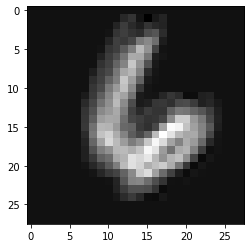

INFO:root:Printing net with fscore value = 1.0
INFO:root:Printing layer number 1 channel number: 0 for predicted value [4] after relu


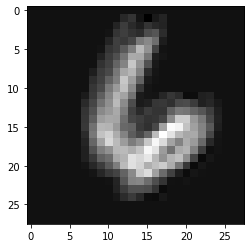

INFO:root:Printing net with fscore value = 1.0
INFO:root:Printing layer number 2 channel number: 0 for predicted value [4]before relu 


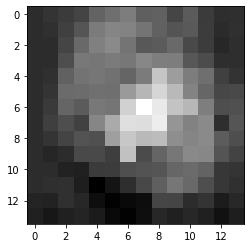

INFO:root:Printing net with fscore value = 1.0
INFO:root:Printing layer number 2 channel number: 0 for predicted value [4] after relu


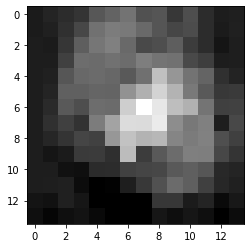

INFO:root:Printing net with fscore value = 1.0
INFO:root:Printing layer number 1 channel number: 0 for predicted value [6]before relu 


*********************************************************************************


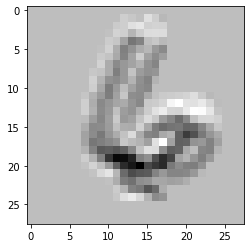

INFO:root:Printing net with fscore value = 1.0
INFO:root:Printing layer number 1 channel number: 0 for predicted value [6] after relu


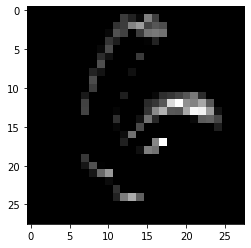

INFO:root:Printing net with fscore value = 1.0
INFO:root:Printing layer number 2 channel number: 0 for predicted value [6]before relu 


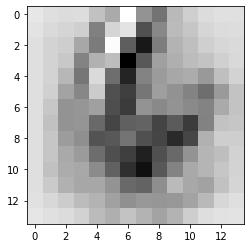

INFO:root:Printing net with fscore value = 1.0
INFO:root:Printing layer number 2 channel number: 0 for predicted value [6] after relu


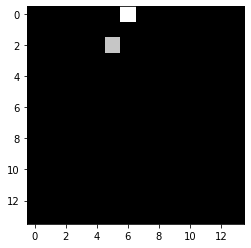

INFO:root:Printing net with fscore value = 0.9258585858585858
INFO:root:Not a convolution network, printing input


*********************************************************************************


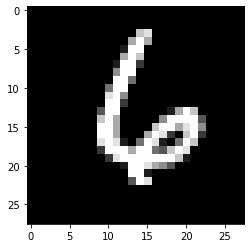

INFO:root:Printing net with fscore value = 0.9258585858585858
INFO:root:Not a convolution network, printing input


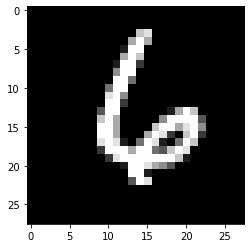

INFO:root:Printing net with fscore value = 0.9258585858585858
INFO:root:Not a convolution network, printing input


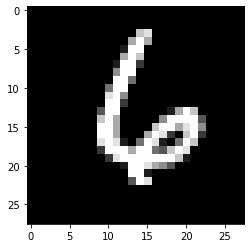

INFO:root:Printing net with fscore value = 0.9258585858585858
INFO:root:Not a convolution network, printing input


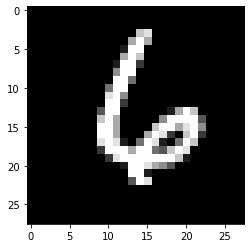

INFO:root:Printing net with fscore value = 0.9193367846463822
INFO:root:Not a convolution network, printing input


*********************************************************************************


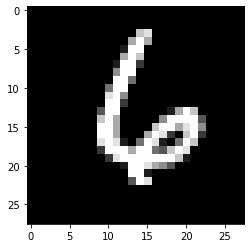

INFO:root:Printing net with fscore value = 0.9193367846463822
INFO:root:Not a convolution network, printing input


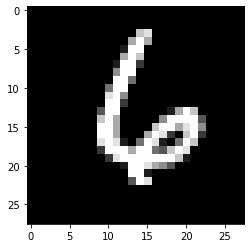

INFO:root:Printing net with fscore value = 0.9193367846463822
INFO:root:Not a convolution network, printing input


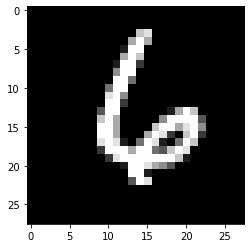

INFO:root:Printing net with fscore value = 0.9193367846463822
INFO:root:Not a convolution network, printing input


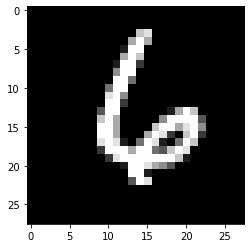

INFO:root:Printing net with fscore value = 0.8679084967320261
INFO:root:Not a convolution network, printing input


*********************************************************************************


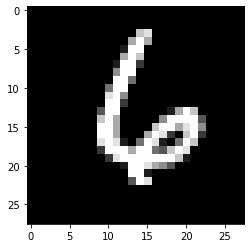

INFO:root:Printing net with fscore value = 0.8679084967320261
INFO:root:Not a convolution network, printing input


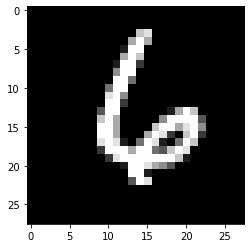

INFO:root:Printing net with fscore value = 0.8679084967320261
INFO:root:Not a convolution network, printing input


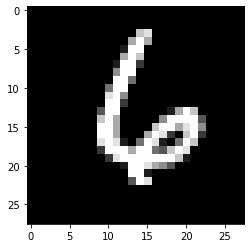

INFO:root:Printing net with fscore value = 0.8679084967320261
INFO:root:Not a convolution network, printing input


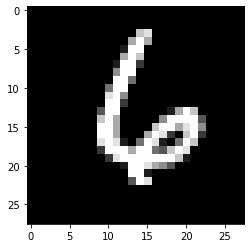

In [9]:
for i in range(300):
    val = np.argmax(mnist.test.labels[i])
    image = mnist.test.images[i]
    if val == 6:
        break
for net_index in range(5):  # print image for 5 networks with best fscores
    print("*********************************************************************************")
    for layer_num in [1, 2]:
        for channel_num in [0]:
            for activation in [True, False]:
                if net_index <= (len(networks) - 1):
                    logging.info("Printing net with fscore value = " + str(networks[net_index].fscore[2]))
                    networks[net_index].visualize(image=image, layer_num=layer_num, channel_num=channel_num, before_activation=activation)


In [10]:
sess.close()
# Eden Dupont
# Daniel Rolnik